# CS412 - Machine Learning - 2024-2025
## Homework 4


## Dataset
[**CelebA**](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

**Download the data from Sucourse and upload it to your Google Drive. You must upload both CelebA30k.zip and CelebA30k.csv to your Drive without renaming them.
CelebA30k is a smaller version of the original CelebA dataset, containing 30,000 images, to reduce computation time during training.
Split the data as follows: reserve 10% of the samples for validation and 10% for testing (i.e., 3,000 samples). The remaining 80% should be used for training.
Important: The test set (3,000 samples) must be used only for final evaluation and not for model selection or hyperparameter tuning.**

## Task

Build a gender classifier using the PyTorch library and a pretrained VGG-16 model on the CelebA dataset. Your goal is to complete the given code without changing the base architecture of VGG-16 (other than replacing the classification head suitable for binary classification).

You will:
- Freeze the convolutional layers of the pretrained model  
- Replace the classifier head with your own binary classification layer  
- Fine-tune the model on the given subset of CelebA  
- Experiment with different values of learning rate, batch size, and number of epochs  

**Dataset:** CelebA  
**Model:** VGG-16
**Library:** PyTorch  

---

## Software

You will use the PyTorch framework for this homework. PyTorch offers flexible tools for deep learning, including pretrained models, custom training loops, and GPU acceleration.

##1) Initialize

*   First make a copy of the notebook given to you as a starter.

*   Make sure you change your runtime to GPU.

## 2) Load training dataset

In [2]:
# load data
#from google.colab import drive
#drive.mount('/content/drive/')

# Load data locally without Google Colab
import pandas as pd

# Define paths to your CSV and image directory
csv_file_path = 'CelebA30k.csv'  # Ensure this file is in the same folder as your notebook
image_dir = 'CelebA30k'          # Ensure this folder is in the same folder as your notebook

# Load the CSV file into pandas DataFrame
data = pd.read_csv(csv_file_path)


In [3]:
# Import necessary libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader, Dataset

import numpy as np # np.random.seed(42) gives an error without this

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [4]:
data = pd.read_csv('CelebA30k.csv') # enter the file path on your drive for the csv file
data.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [5]:
gender_data = data[['filename', 'Male']].copy()
gender_data.head()

,filename,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1


In [6]:
# This will extract the contents of the zip file into a folder named data
# Do not extract the zip into your google drive

#!unzip "/content/drive/My Drive/CS412/hw4/CelebA30k.zip" -d "/content/data"

In [7]:
#first_image_path = os.path.join("CelebA30k/", gender_data.loc[0,"filename"])
#img = Image.open(first_image_path)

from PIL import Image
import os

first_image_path = os.path.join('CelebA30k/CelebA30k', gender_data.loc[0,'filename'])
img = Image.open(first_image_path)



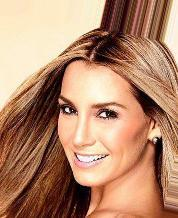

In [8]:
img

# Starting here, you’ll need to fill in the code cells on your own.

##3) Visualizing/Understanding the dataset

- Display five random images together with their labels

- Display statistics about the dataset, such as distribution of labels, etc.


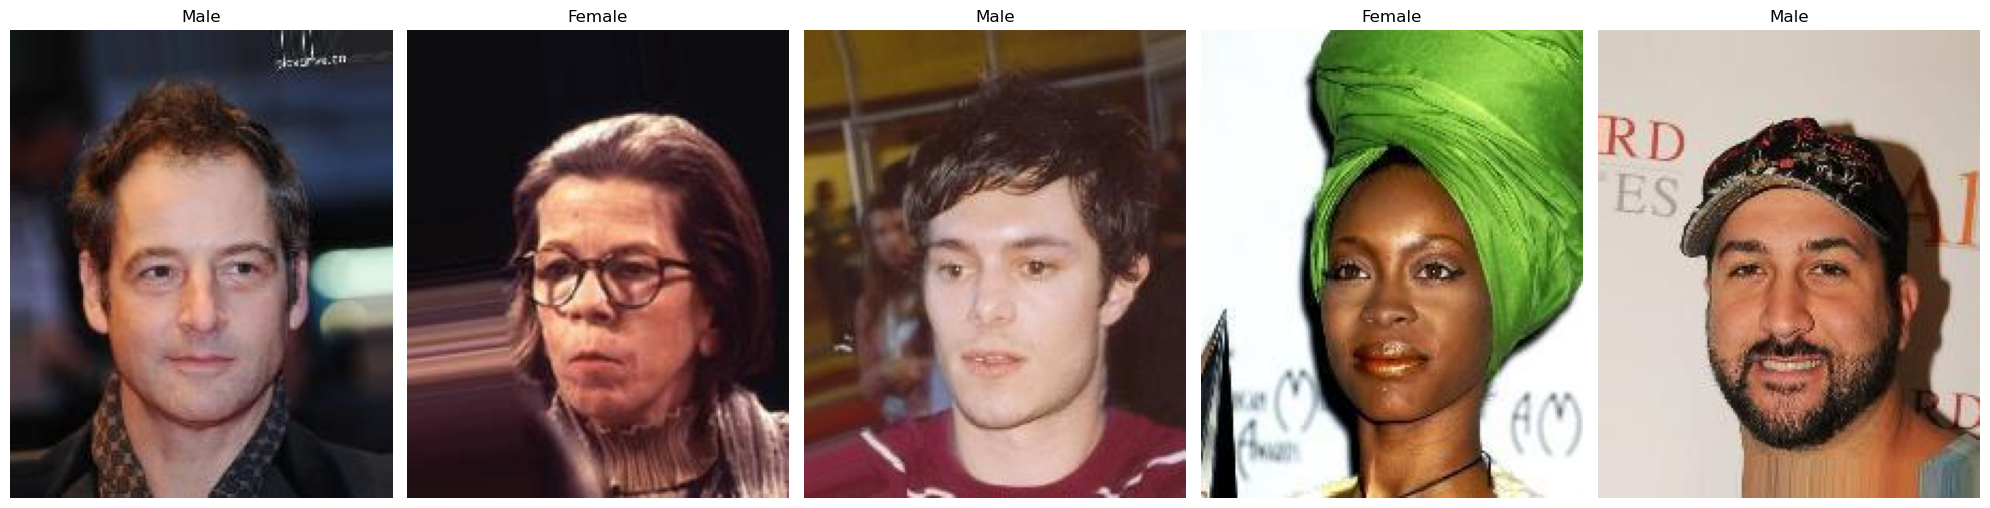

Label distribution:
         count  percent
Male                  
Female  17320    57.73
Male    12680    42.27 



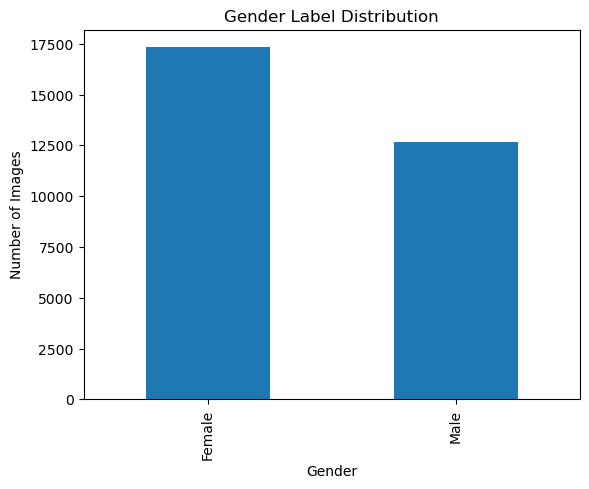

In [9]:
# 3) Visualizing/Understanding the dataset

# where your images live (after unzipping into /content/data)
image_dir = 'CelebA30k/CelebA30k'

# 1. Display five random images with their labels
sample_df = gender_data.sample(n=5, random_state=42).reset_index(drop=True)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, row in sample_df.iterrows():
    img_path = os.path.join(image_dir, row['filename'])
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title('Male' if row['Male']==1 else 'Female')
plt.tight_layout()
plt.show()

# 2. Display dataset statistics
label_map = {1: 'Male', -1: 'Female'}
mapped = gender_data['Male'].map(label_map)

# counts and percentages
counts = mapped.value_counts()
percent = counts / counts.sum() * 100
stats = pd.DataFrame({'count': counts, 'percent': percent.round(2)})

print("Label distribution:\n", stats, "\n")

# 3. Bar chart of the distribution
stats['count'].plot(kind='bar')
plt.title('Gender Label Distribution')
plt.xlabel('Gender')
plt.ylabel('Number of Images')
plt.show()



##4) Split the dataset as train (80%), validation (10%) and test (10%) set.

In [10]:
# 4) Split the dataset as train (80%), validation (10%) and test (10%) set.

# First split off 20% for temp (val+test), stratifying on the label to keep class balance
train_df, temp_df = train_test_split(
    gender_data,
    test_size=0.20,
    stratify=gender_data['Male'],
    random_state=42
)

# Then split the temp set in half: 10% val, 10% test (i.e. 50/50 of the 20%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['Male'],
    random_state=42
)

# Sanity check: print sizes and class distributions
print(f"Train set:      {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set:       {len(test_df)} samples\n")

print("Label distribution (train):")
print(train_df['Male'].value_counts(normalize=True).rename('proportion').round(3))
print("\nLabel distribution (val):")
print(val_df['Male'].value_counts(normalize=True).rename('proportion').round(3))
print("\nLabel distribution (test):")
print(test_df['Male'].value_counts(normalize=True).rename('proportion').round(3))


Train set:      24000 samples
Validation set: 3000 samples
Test set:       3000 samples

Label distribution (train):
Male
-1    0.577
 1    0.423
Name: proportion, dtype: float64

Label distribution (val):
Male
-1    0.577
 1    0.423
Name: proportion, dtype: float64

Label distribution (test):
Male
-1    0.577
 1    0.423
Name: proportion, dtype: float64


## 5) Preparing the Data

In this section, you will implement the dataset loading and preprocessing pipeline using PyTorch.

You are provided with:
- `train_df` and `val_df` dataframes, which include two columns: `filename`  and `Male`
- A directory path (`/content/data/CelebA30k`) that contains the image files

Your task is to:
1. Define appropriate transformations using `torchvision.transforms` for the training and validation sets
   - Resize images to 224x224
   - Convert them to tensors
   - Normalize them (you can use `[0.5], [0.5]` for simplicity)
   - Add data augmentation (e.g., horizontal flip) for training
2. Write a custom `Dataset` class that reads images and labels from the dataframe
3. Create `DataLoader` objects for training and validation with an appropriate batch size

In [11]:
# 5) Preparing the Data

# 1. Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# 2. Custom Dataset
class CelebADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        # map -1→0 (female), 1→1 (male)
        label = 1 if row['Male'] == 1 else 0
        return img, label

# 3. Create Dataset and DataLoader objects
image_dir = 'CelebA30k/CelebA30k'

train_dataset = CelebADataset(train_df, image_dir, transform=train_transforms)
val_dataset   = CelebADataset(val_df,   image_dir, transform=val_transforms)

batch_size = 32

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=False)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=0,
                        pin_memory=False)

# Sanity check – look at one batch
imgs, labs = next(iter(train_loader))
print(f"Batch of images: {imgs.shape}, labels: {labs.shape}")


Batch of images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32])


## 6) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 architecture available in torchvision.models. This model is pretrained on the ImageNet dataset, a large dataset containing 1.4 million images and 1,000 object categories.

In transfer learning, we use the convolutional base of the pretrained model as a feature extractor. However, we do not use the last fully connected layer, which is specific to ImageNet’s 1,000-class classification task. Instead, we will:
- Keep the convolutional layers (which extract general visual features)
- Remove the final classification layer
- Replace it with our own binary classifier (for gender classification)

This is a common strategy because the layer before the original classification head (the so-called "bottleneck layer") retains high-level, general features useful for a wide range of vision tasks.

### Instructions

You should:
1. Load the VGG-16 model with pretrained=True from torchvision.models.
2. Replace the classifier head with a new sequence of layers suitable for binary classification:
   - The final output should have one neuron (output dimension = 1).
   - Do not apply a Sigmoid activation after the output layer, because the loss function you will use internally applies it.


In [12]:
# 6) Transfer Learning with VGG-16

# 1. Load the pretrained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

# 2. Freeze all convolutional (feature) layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# 3. Replace the classifier head for binary output
#    - Grab the in_features of the original first classifier layer
in_features = vgg16.classifier[0].in_features

vgg16.classifier = nn.Sequential(
    nn.Linear(in_features, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 1)   # single output neuron, no sigmoid here
)

# 4. Move model to GPU (if available)
model = vgg16.to(device)

# Print the modified architecture to verify
print(model)


C:\Users\Monster\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Monster\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 7) Fine-Tuning and Training the Model

Now that your VGG-16 base model is set up with a new binary classification head, it’s time to fine-tune and train it using your `train_loader` and evaluate it using your `val_loader`.

You will:
- Experiment with two different fine-tuning strategies:
  - Freeze all convolutional layers and train only the classifier head.
  - Unfreeze the last convolutional block and the classifier head, and train them.
- Choose an appropriate optimizer (e.g., `torch.optim.SGD` or `Adam`).
- Use `nn.BCEWithLogitsLoss()` as the loss function.
  - Note: Since you are using nn.BCEWithLogitsLoss(), your model's output should not have a Sigmoid activation. This loss function applies the Sigmoid operation internally.
- Implement a training loop that includes validation after each epoch.
- Monitor both training and validation performance across epochs.

Hyperparameter Tuning:
- Try two different learning rates: 0.001 and 0.0001.
- The number of training epochs must be fixed to 10.
- You may adjust batch size depending on available GPU memory, but typically 32 or 64 is suggested.

Finally, you should report:
- Final training and validation accuracy for each configuration.
- A plot showing training and validation loss across epochs.
- A brief discussion comparing the results for different fine-tuning strategies and learning rates, identifying which combination performed best and why.




=== Strategy: head_only, LR: 0.001 ===


train | Epoch  1/10 | Loss: 0.2689 | Acc: 0.9172


val   | Epoch  1/10 | Loss: 0.1635 | Acc: 0.9427


train | Epoch  2/10 | Loss: 0.1691 | Acc: 0.9391


val   | Epoch  2/10 | Loss: 0.2102 | Acc: 0.9263


train | Epoch  3/10 | Loss: 0.1413 | Acc: 0.9498


val   | Epoch  3/10 | Loss: 0.1569 | Acc: 0.9417


train | Epoch  4/10 | Loss: 0.1276 | Acc: 0.9566


val   | Epoch  4/10 | Loss: 0.1670 | Acc: 0.9427


train | Epoch  5/10 | Loss: 0.1054 | Acc: 0.9641


val   | Epoch  5/10 | Loss: 0.1813 | Acc: 0.9380


train | Epoch  6/10 | Loss: 0.0829 | Acc: 0.9720


val   | Epoch  6/10 | Loss: 0.2042 | Acc: 0.9440


train | Epoch  7/10 | Loss: 0.0877 | Acc: 0.9716


val   | Epoch  7/10 | Loss: 0.1933 | Acc: 0.9487


train | Epoch  8/10 | Loss: 0.0895 | Acc: 0.9711


val   | Epoch  8/10 | Loss: 0.2104 | Acc: 0.9493


train | Epoch  9/10 | Loss: 0.0710 | Acc: 0.9776


val   | Epoch  9/10 | Loss: 0.2282 | Acc: 0.9473


train | Epoch 10/10 | Loss: 0.0729 | Acc: 0.9765


val   | Epoch 10/10 | Loss: 0.2217 | Acc: 0.9500


=== Strategy: head_only, LR: 0.0001 ===


train | Epoch  1/10 | Loss: 0.1824 | Acc: 0.9301


val   | Epoch  1/10 | Loss: 0.1473 | Acc: 0.9437


train | Epoch  2/10 | Loss: 0.1244 | Acc: 0.9523


val   | Epoch  2/10 | Loss: 0.1476 | Acc: 0.9450


train | Epoch  3/10 | Loss: 0.1002 | Acc: 0.9642


val   | Epoch  3/10 | Loss: 0.1483 | Acc: 0.9457


train | Epoch  4/10 | Loss: 0.0811 | Acc: 0.9699


val   | Epoch  4/10 | Loss: 0.1548 | Acc: 0.9497


train | Epoch  5/10 | Loss: 0.0641 | Acc: 0.9769


val   | Epoch  5/10 | Loss: 0.2071 | Acc: 0.9377


train | Epoch  6/10 | Loss: 0.0562 | Acc: 0.9785


val   | Epoch  6/10 | Loss: 0.1725 | Acc: 0.9483


train | Epoch  7/10 | Loss: 0.0499 | Acc: 0.9814


val   | Epoch  7/10 | Loss: 0.1884 | Acc: 0.9440


train | Epoch  8/10 | Loss: 0.0339 | Acc: 0.9872


val   | Epoch  8/10 | Loss: 0.1847 | Acc: 0.9497


train | Epoch  9/10 | Loss: 0.0334 | Acc: 0.9876


val   | Epoch  9/10 | Loss: 0.2195 | Acc: 0.9477


train | Epoch 10/10 | Loss: 0.0315 | Acc: 0.9887


val   | Epoch 10/10 | Loss: 0.2167 | Acc: 0.9487


=== Strategy: fine_tune, LR: 0.001 ===


train | Epoch  1/10 | Loss: 0.7036 | Acc: 0.5767


val   | Epoch  1/10 | Loss: 0.6812 | Acc: 0.5773


train | Epoch  2/10 | Loss: 0.6815 | Acc: 0.5773


val   | Epoch  2/10 | Loss: 0.6813 | Acc: 0.5773


train | Epoch  3/10 | Loss: 0.6815 | Acc: 0.5773


val   | Epoch  3/10 | Loss: 0.6815 | Acc: 0.5773


train | Epoch  4/10 | Loss: 0.6815 | Acc: 0.5773


val   | Epoch  4/10 | Loss: 0.6812 | Acc: 0.5773


train | Epoch  5/10 | Loss: 0.6815 | Acc: 0.5773


val   | Epoch  5/10 | Loss: 0.6815 | Acc: 0.5773


train | Epoch  6/10 | Loss: 0.6813 | Acc: 0.5773


val   | Epoch  6/10 | Loss: 0.6812 | Acc: 0.5773


train | Epoch  7/10 | Loss: 0.6816 | Acc: 0.5773


val   | Epoch  7/10 | Loss: 0.6812 | Acc: 0.5773


train | Epoch  8/10 | Loss: 0.6816 | Acc: 0.5773


val   | Epoch  8/10 | Loss: 0.6811 | Acc: 0.5773


train | Epoch  9/10 | Loss: 0.6816 | Acc: 0.5773


val   | Epoch  9/10 | Loss: 0.6817 | Acc: 0.5773


train | Epoch 10/10 | Loss: 0.6816 | Acc: 0.5773


val   | Epoch 10/10 | Loss: 0.6816 | Acc: 0.5773


=== Strategy: fine_tune, LR: 0.0001 ===


train | Epoch  1/10 | Loss: 0.1258 | Acc: 0.9509


val   | Epoch  1/10 | Loss: 0.1074 | Acc: 0.9577


train | Epoch  2/10 | Loss: 0.0645 | Acc: 0.9766


val   | Epoch  2/10 | Loss: 0.0814 | Acc: 0.9687


train | Epoch  3/10 | Loss: 0.0457 | Acc: 0.9848


val   | Epoch  3/10 | Loss: 0.0786 | Acc: 0.9727


train | Epoch  4/10 | Loss: 0.0327 | Acc: 0.9892


val   | Epoch  4/10 | Loss: 0.1199 | Acc: 0.9640


train | Epoch  5/10 | Loss: 0.0263 | Acc: 0.9913


val   | Epoch  5/10 | Loss: 0.0919 | Acc: 0.9710


train | Epoch  6/10 | Loss: 0.0223 | Acc: 0.9925


val   | Epoch  6/10 | Loss: 0.1014 | Acc: 0.9757


train | Epoch  7/10 | Loss: 0.0164 | Acc: 0.9943


val   | Epoch  7/10 | Loss: 0.1182 | Acc: 0.9713


train | Epoch  8/10 | Loss: 0.0166 | Acc: 0.9942


val   | Epoch  8/10 | Loss: 0.0908 | Acc: 0.9740


train | Epoch  9/10 | Loss: 0.0139 | Acc: 0.9949


val   | Epoch  9/10 | Loss: 0.1086 | Acc: 0.9737


train | Epoch 10/10 | Loss: 0.0135 | Acc: 0.9953


val   | Epoch 10/10 | Loss: 0.0866 | Acc: 0.9787


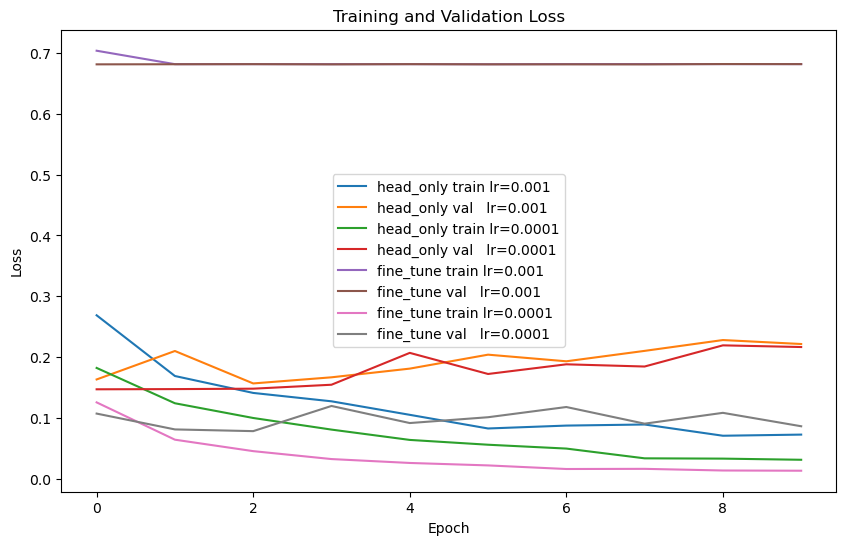

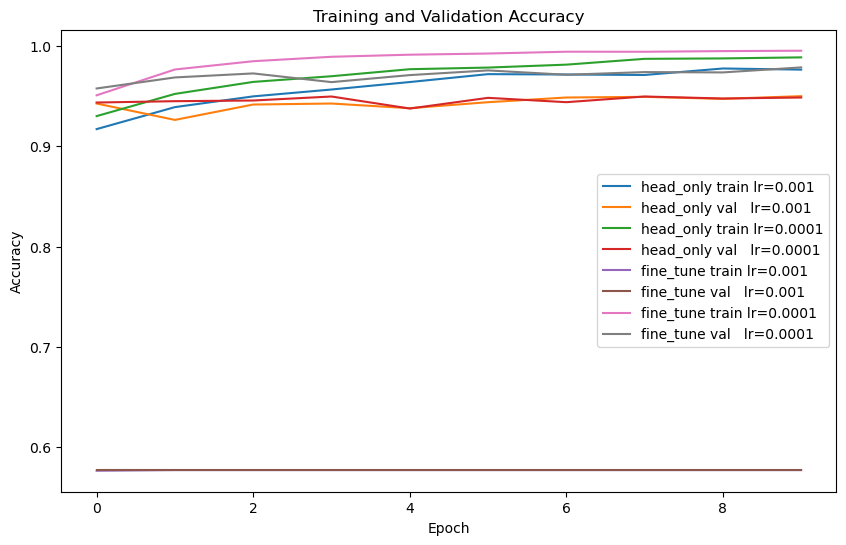

In [13]:
# 7) Fine-Tuning and Training the Model

from tqdm import tqdm

# Define the two strategies and learning rates to try
configs = [
    ('head_only', 1e-3),
    ('head_only', 1e-4),
    ('fine_tune', 1e-3),
    ('fine_tune', 1e-4),
]

num_epochs = 10
histories = {}

for strategy, lr in configs:
    print(f"\n\n=== Strategy: {strategy}, LR: {lr} ===")
    # 1) Load a fresh VGG-16 pretrained model
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    # 2) Freeze all conv layers
    for param in model.features.parameters():
        param.requires_grad = False
    # 3) Replace classifier head
    in_feat = model.classifier[0].in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_feat, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 1)
    )
    # 4) If fine-tuning, unfreeze the last conv block (features[24:])
    if strategy == 'fine_tune':
        for layer in model.features[24:]:
            for param in layer.parameters():
                param.requires_grad = True

    model = model.to(device)

    # 5) Prepare optimizer & loss
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params_to_update, lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # 6) Training loop with validation each epoch
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(num_epochs):
        for phase, loader in [('train', train_loader), ('val', val_loader)]:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(loader, desc=f"{phase} Epoch {epoch+1}/{num_epochs}", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = (torch.sigmoid(outputs) >= 0.5).float()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

            print(f"{phase:5s} | Epoch {epoch+1:2d}/{num_epochs} | "
                  f"Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

    histories[(strategy, lr)] = history

# 7a) Plot training & validation loss curves for all configs
plt.figure(figsize=(10, 6))
for (strategy, lr), h in histories.items():
    plt.plot(h['train_loss'], label=f"{strategy} train lr={lr}")
    plt.plot(h['val_loss'],   label=f"{strategy} val   lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# 7b) Plot training & validation accuracy curves
plt.figure(figsize=(10, 6))
for (strategy, lr), h in histories.items():
    plt.plot(h['train_acc'], label=f"{strategy} train lr={lr}")
    plt.plot(h['val_acc'],   label=f"{strategy} val   lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


## 8) Test your classifier on Test set

- Use your model to predict the labels of the test set and report the final accuracy.

In [15]:
# 8) Test your classifier on Test set

# 1. Create the test DataLoader (if not already defined)
test_dataset = CelebADataset(test_df, image_dir, transform=val_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

# 2. Evaluate on test set
model.eval()
running_corrects = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) >= 0.5).float()

        running_corrects += torch.sum(preds == labels)
        total_samples += inputs.size(0)

test_acc = running_corrects.double() / total_samples
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9770
